# Temporal auto-correlation

Assessment of model temporal auto-correlation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from xskillscore import pearson_r, pearson_r_p_value

sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [2]:
def resample(da, var):
    """Calculate the lag1 auto-correlation"""
    
    if var == 'pr':
        ds = da.groupby('time.year').sum(dim='time')       
    else:
        ds = da.groupby('time.year').mean(dim='time')
        
    return  ds

In [3]:
def get_data(var, gcm, rcm, task):
    """Get data needed for the evaluation"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']
    
    if gcm == 'ECMWF-ERA5':
        start_date = '2000-01-01' if task == 'xvalidation' else '1980-01-01'
    else:
        start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    da_dict = {}
    
    da_dict['obs'] = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
   
    da_dict['gcm'] = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_raw'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_ecdfm'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_qme'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    if task == 'xvalidation':
        da_dict['rcm_qdm'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
            'AU'
        )
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict

In [4]:
def plot_mean_bias(ax, da_obs, da_model, var, cmap, levels, model_name, ob_fractions=None):
    """Plot the mean bias for a particular model"""
    
    resampled_obs = resample(da_obs, var)
    resampled_obs = resampled_obs.compute()
    resampled_model = resample(da_model, var)
    resampled_model = resampled_model.compute()
    
    def _lag_correlate(x, dim, lead, return_p):
        """Helper function to shift the two time series and correlate."""
        N = x[dim].size
        normal = x.isel({dim: slice(0, N - lead)})
        shifted = x.isel({dim: slice(0 + lead, N)})
        # Align dimensions for xarray operation.
        shifted[dim] = normal[dim]
        corrcoef = pearson_r(normal, shifted, dim)
        if return_p:
            pval = pearson_r_p_value(normal, shifted, dim)
            return corrcoef, pval
        else:
            return corrcoef
            
    obs_lag1 = _lag_correlate(resampled_obs, 'year', lead=1, return_p=False)
    model_lag1 = _lag_correlate(resampled_model, 'year', lead=1, return_p=False)

    bias = model_lag1 - obs_lag1
    
    bias = utils.clip_data(bias, utils.get_aus_shape())
    if ob_fractions is not None:
        bias = utils.mask_by_pr_ob_fraction(bias, ob_fractions, threshold=0.9)  
    mae = np.nanmean(np.abs(bias))    
    
    units = 'Pearson CC'
    bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        cbar_kwargs={'label': units},
    )
    ax.text(0.02, 0.02, f'MAE: {mae:.2f} {units}', transform=ax.transAxes)
    ax.set_title(model_name)
    ax.coastlines()


In [5]:
def plot_comparison(var, gcm, rcm, task, cmap, levels):
    """Plot the complete comparison"""

    da_dict = get_data(var, gcm, rcm, task)
    if var == 'pr':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None
    
    ncols = 5 if task == 'xvalidation' else 4
    fig = plt.figure(figsize=[7 * ncols, 5])
    ax1 = fig.add_subplot(1, ncols, 1, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax1, da_dict['obs'], da_dict['gcm'], var, cmap, levels, gcm, ob_fractions=ob_fractions
    )
    ax2 = fig.add_subplot(1, ncols, 2, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax2, da_dict['obs'], da_dict['rcm_raw'], var, cmap, levels, f'{rcm} (raw)', ob_fractions=ob_fractions
    )
    ax3 = fig.add_subplot(1, ncols, 3, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax3, da_dict['obs'], da_dict['rcm_ecdfm'], var, cmap, levels, f'{rcm} (ecdfm)', ob_fractions=ob_fractions
    )
    ax4 = fig.add_subplot(1, ncols, 4, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax4, da_dict['obs'], da_dict['rcm_qme'], var, cmap, levels, f'{rcm} (qme)', ob_fractions=ob_fractions
    )
    if task == 'xvalidation':
        ax5 = fig.add_subplot(1, ncols, 5, projection=ccrs.PlateCarree())
        plot_mean_bias(
            ax5, da_dict['obs'], da_dict['rcm_qdm'], var, cmap, levels, f'{rcm} (qdm)', ob_fractions=ob_fractions
        ) 
    
    long_name = da_dict['rcm_raw'].attrs['long_name']
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    plt.suptitle(f'Lag-1-correlation bias (model minus obs) in the {start_year}-2019 annual mean {long_name}')
    plt.show()

In [6]:
cities = {
    'Port Hedland': {'lat': -20.3, 'lon': 118.6},
    'Alice Springs': {'lat': -23.7, 'lon': 133.9},
    'Darwin': {'lat': -12.5, 'lon': 131},
    'Cairns': {'lat': -16.9, 'lon': 145},
    'Brisbane': {'lat': -27.5, 'lon': 153.0},
    'Sydney': {'lat': -33.9, 'lon': 151.2},
    'Thredbo': {'lat': -36.5, 'lon': 148.3},
    'Melbourne': {'lat': -37.8, 'lon': 145.0},
    'Hobart': {'lat': -42.9, 'lon': 147.3},
    'Adelaide': {'lat': -34.9, 'lon': 138.6},
    'Perth': {'lat': -32.0, 'lon': 115.9},    
}
colours=['bo','co','go','ro','mo','ko']

In [7]:
def plot_city(ax, xticks, var, da, city, colour,  name):
    """Plot ACF"""
    da = resample(da, var)
    da_point = da.sel(cities[city], method='nearest')
    lag1_tac = sm.tsa.acf(da_point.values, nlags = len(da_point.values)-1)

    # ax.stem(xticks, lag1_tac, 'grey', markerfmt = colour, label=name)
    tsaplots.plot_acf(da_point, ax=ax ,lags = len(da_point.values)-1, label=name);
    from matplotlib.collections import PolyCollection, LineCollection
    for item in ax.collections:
        # change the color of the confidence interval 
        if type(item) == PolyCollection:
            item.set_facecolor('whitesmoke')

In [8]:
def plot_city_tac(var, gcm, rcm, task):
    """Plot ACF for a bunch of cities"""
        
    da_dict = get_data(var, gcm, rcm, task)
    
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980' 
    end_year = '2019'
  
    xticks = np.arange(0,len(np.arange(int(start_year), int(end_year)+1)))
    xtick_labels = [np.arange(int(start_year), int(end_year)+1)[i] for i in xticks]
    
    fig = plt.figure(figsize=[20, 48])
    for plotnum, city in enumerate(cities):
        ax = fig.add_subplot(6, 2, plotnum+1)
        plot_city(ax, xticks, var, da_dict['obs'], city, colours[0], 'AGCD')
        plot_city(ax, xticks, var, da_dict['gcm'], city, colours[1], gcm)
        plot_city(ax, xticks, var, da_dict['rcm_raw'], city, colours[2], rcm)
        plot_city(ax, xticks, var, da_dict['rcm_ecdfm'], city, colours[3], f'{rcm} (ECDFm)')
        plot_city(ax, xticks, var, da_dict['rcm_qme'], city, colours[4], f'{rcm} (QME)')
        if task == 'xvalidation':
            plot_city(ax, xticks, var, da_dict['rcm_qdm'], city, colours[5], f'{rcm} (QDM)')
        ax.set_title(city)
        ax.set_ylabel(f'Autocorrelation Function (ACF)')
        ax.set_xticks(xticks, xtick_labels, rotation=90)
        ax.set_yticks(np.arange(-1,1.25,0.25))
        ax.set_ylim(-1,1.1)
        # if plotnum == 0:
        # ax.legend()
        handles, labels= ax.get_legend_handles_labels()
        handles=handles[1::2]
        labels =labels[1::2]
        ax.legend(handles=handles, labels=labels,loc='best',shadow=True, numpoints=2)


        
        ax.grid(axis='y', which='major', color='grey', linewidth=0.3, linestyle=':')

    long_name = da_dict['rcm_raw'].attrs['long_name']
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    plt.suptitle(f'Annual temporal auto-correlation in the {start_year}-2019 {long_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# task-historical
Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [9]:
variable = 'tasmin'
levels = np.arange(-0.95, 0.96, 0.1)
cmap = 'RdBu_r'

### ERA5

In [ ]:
plot_city_tac(variable, 'ECMWF-ERA5', 'BOM-BARPA-R', 'historical')

In [ ]:
plot_city_tac(variable, 'ECMWF-ERA5', 'CSIRO-CCAM-2203', 'historical')

In [ ]:
plot_city_tac(variable, 'ECMWF-ERA5', 'UQ-DES-CCAM-2105', 'historical')

### ACCESS-ESM1-5

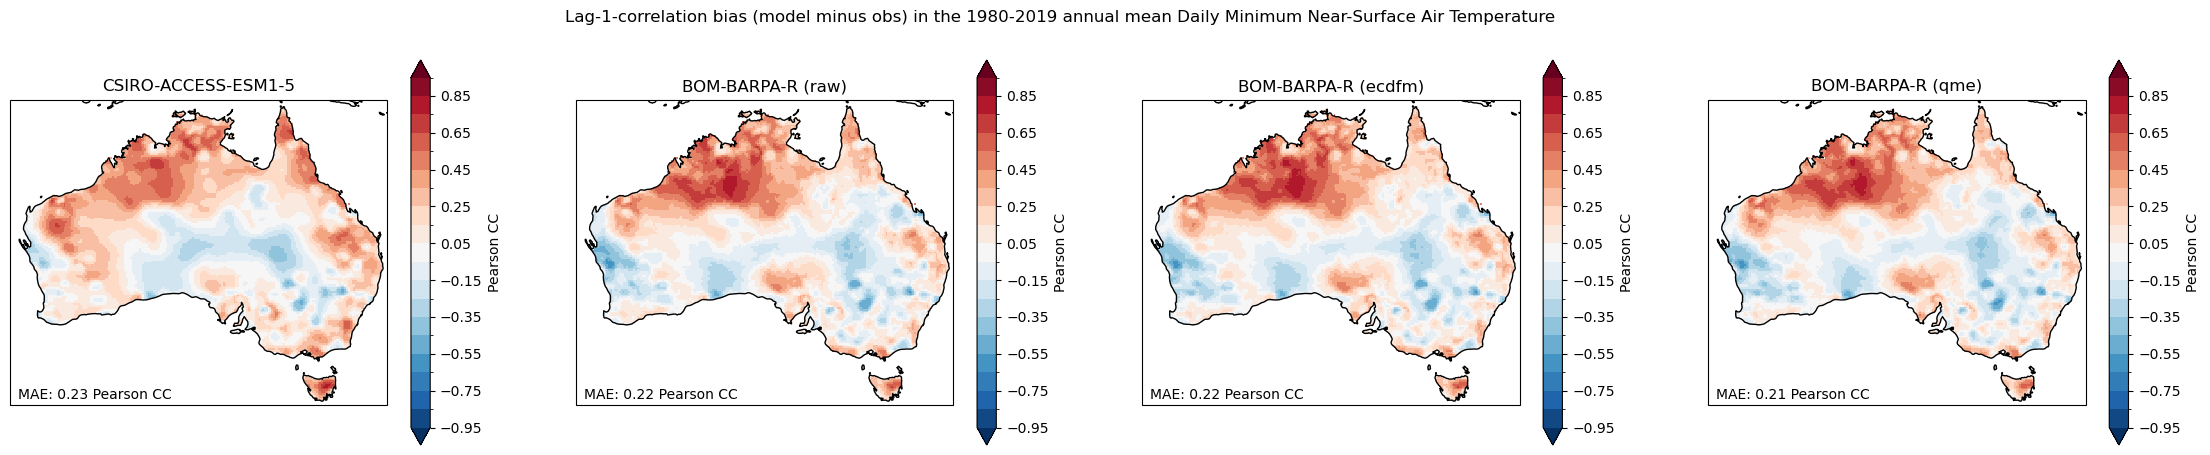

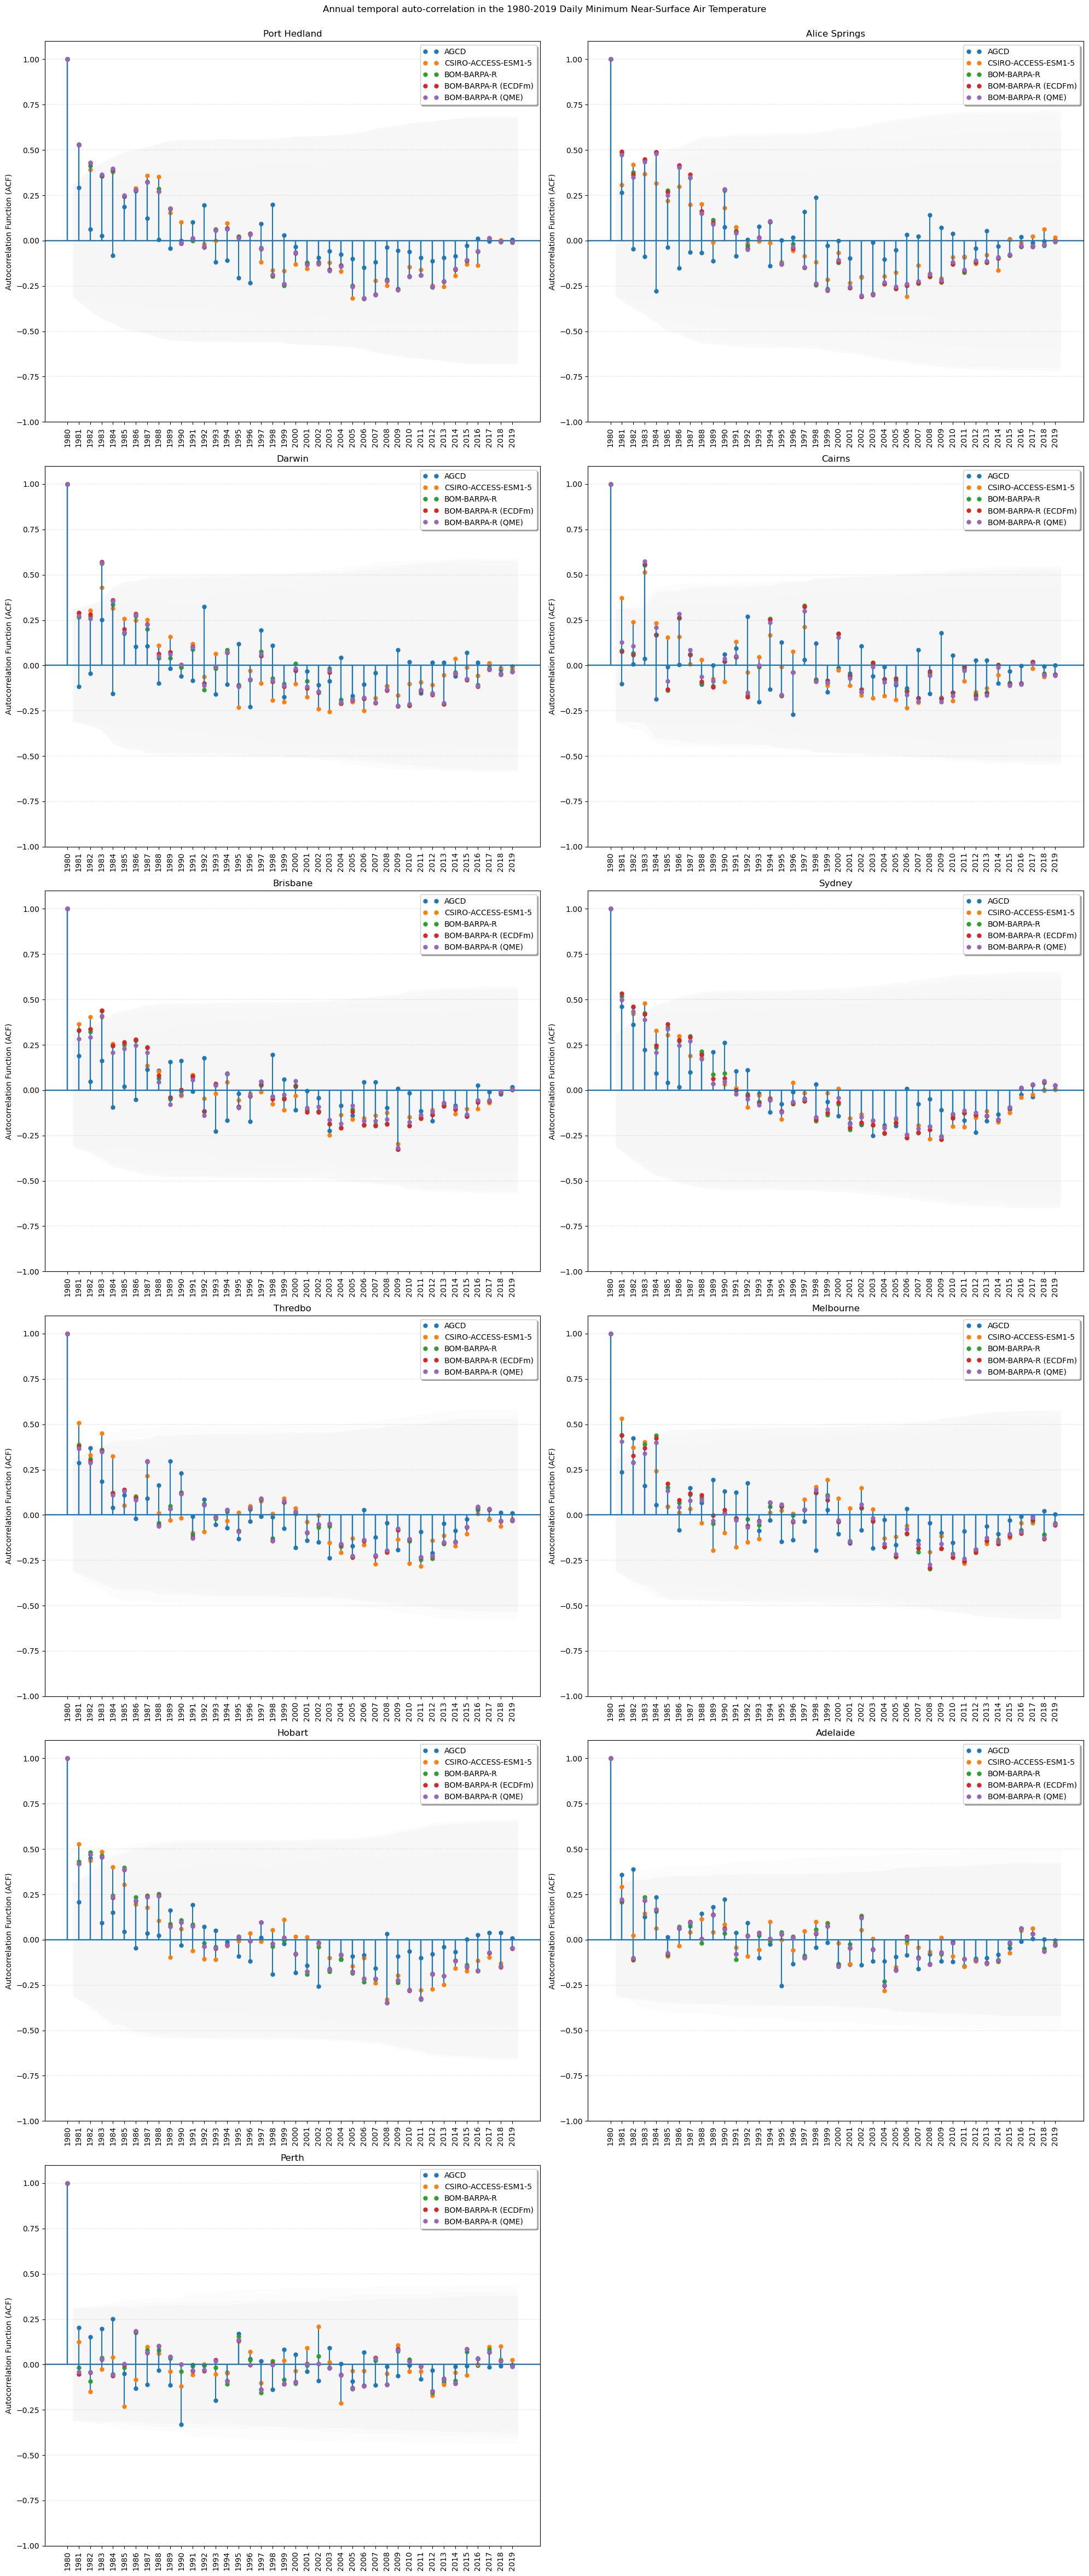

In [10]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'historical', cmap, levels)
plot_city_tac(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'historical')

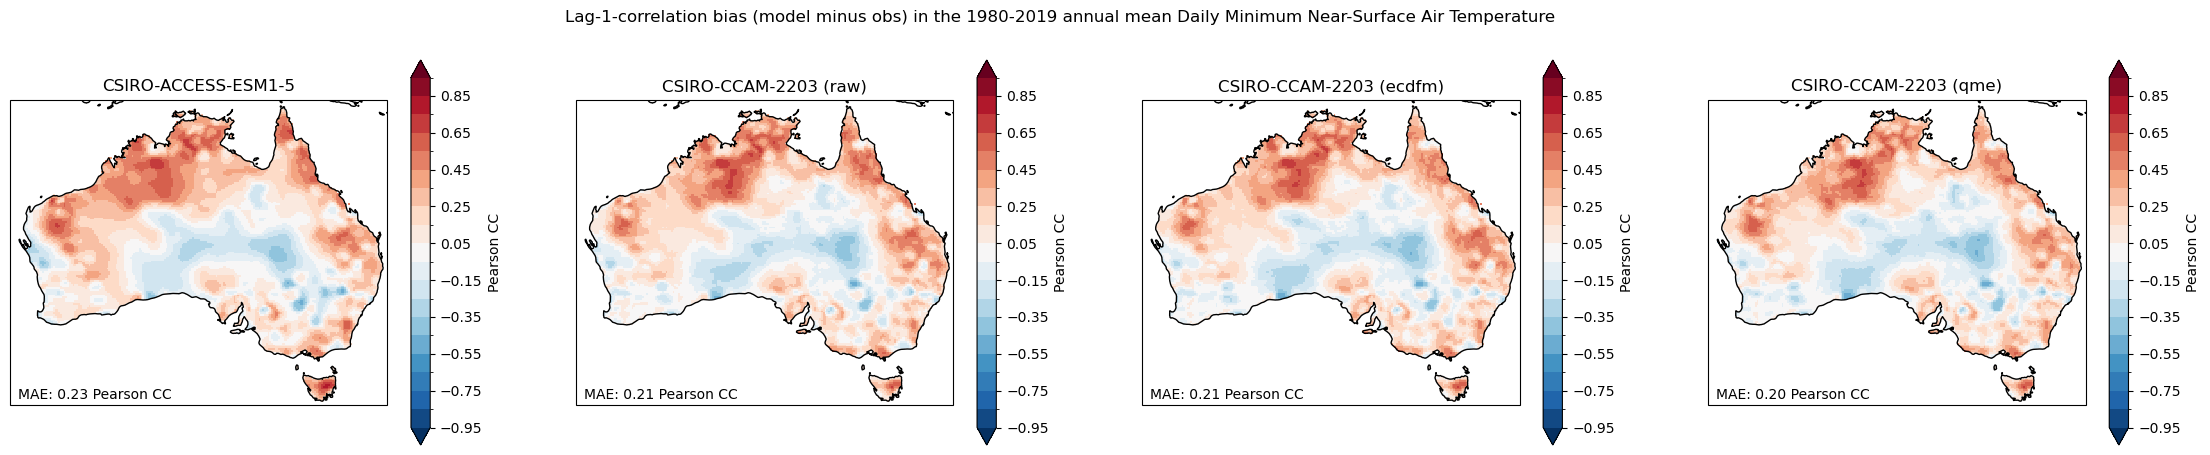

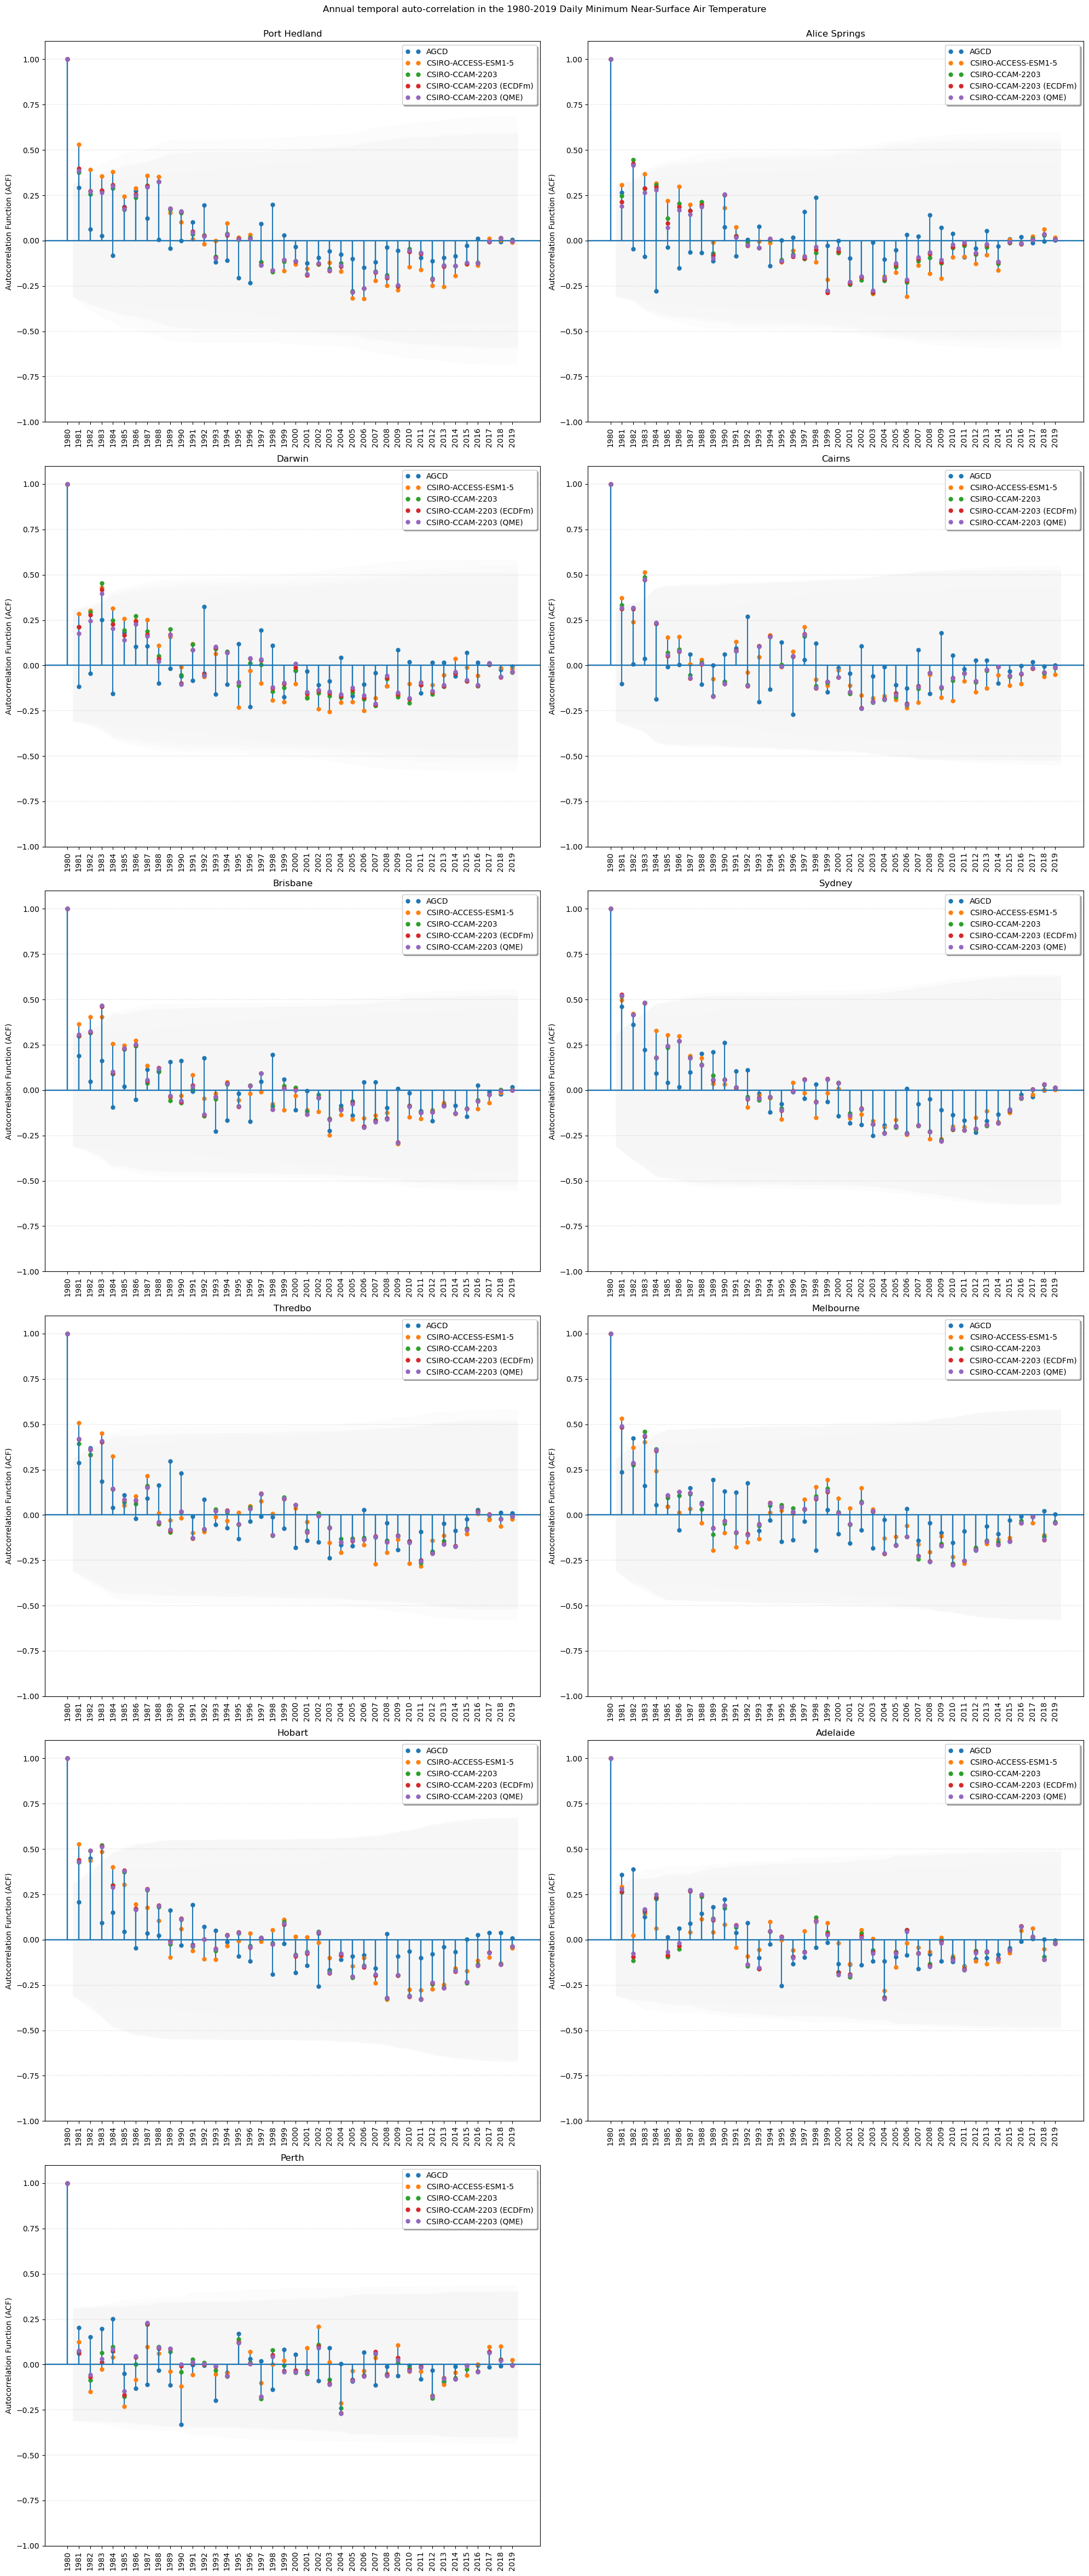

In [11]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'historical', cmap, levels)
plot_city_tac(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'historical')

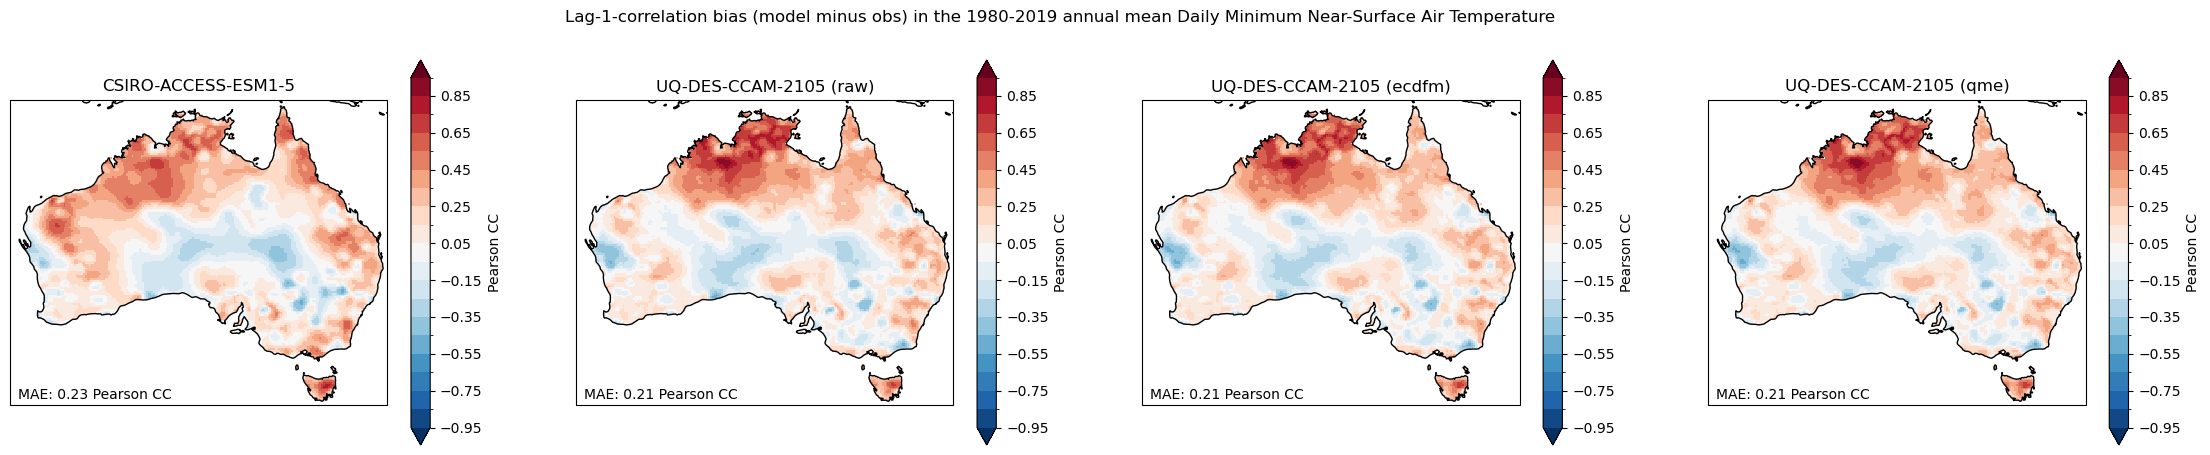

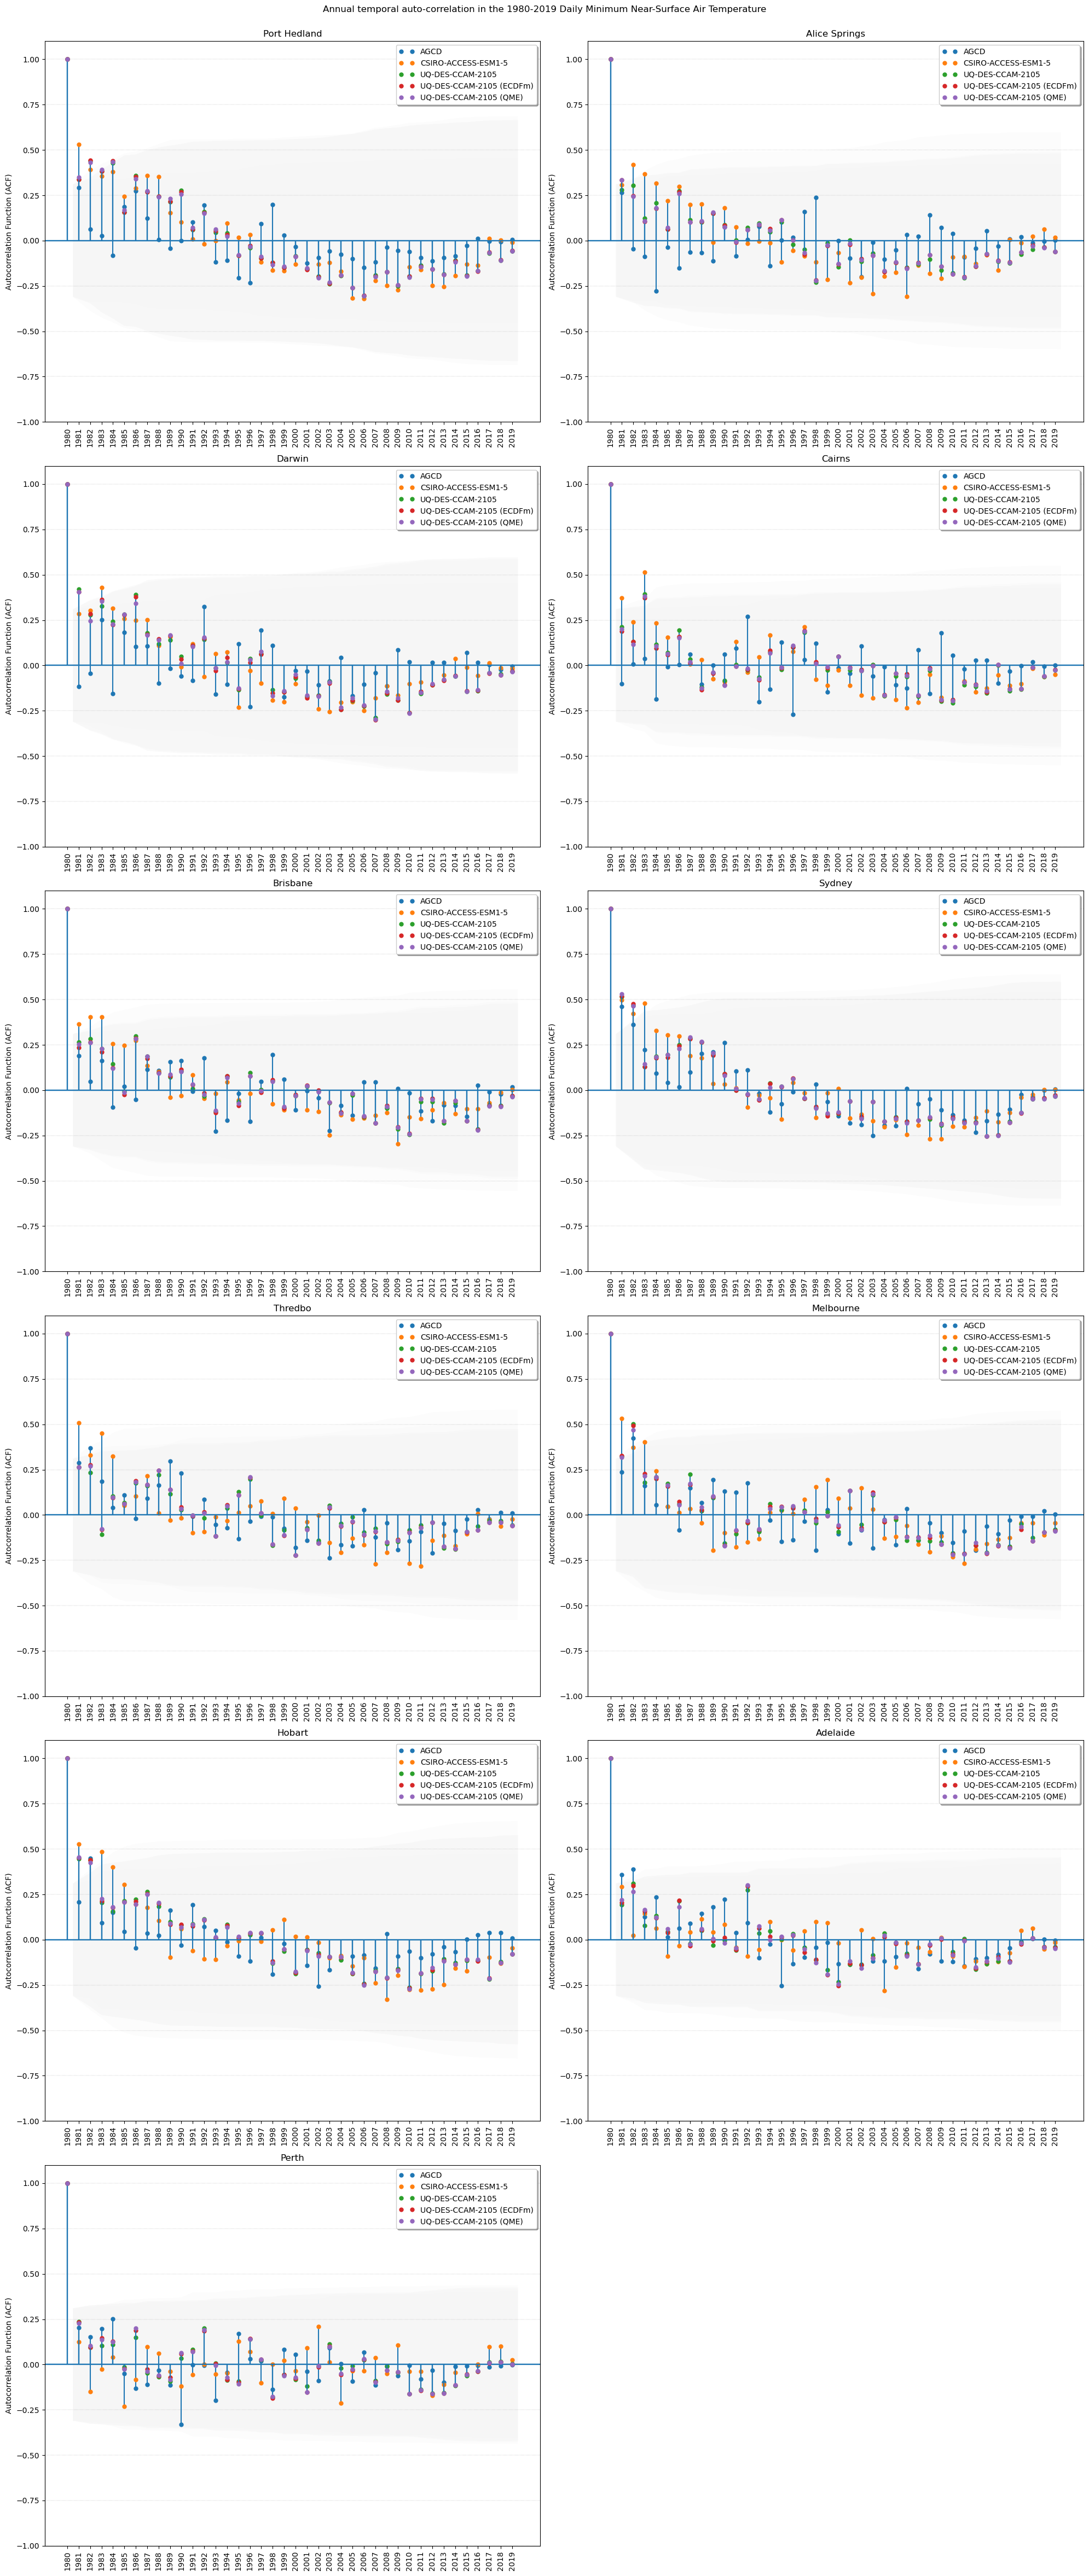

In [22]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'historical', cmap, levels)
plot_city_tac(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'historical')

# task-xvalidation

### ERA5
Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

In [ ]:
plot_city_tac(variable, 'ECMWF-ERA5', 'BOM-BARPA-R', 'xvalidation')

In [ ]:
plot_city_tac(variable, 'ECMWF-ERA5', 'CSIRO-CCAM-2203', 'xvalidation')

In [ ]:
plot_city_tac(variable, 'ECMWF-ERA5', 'UQ-DES-CCAM-2105', 'xvalidation')

### ACCESS-ESM1-5
Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

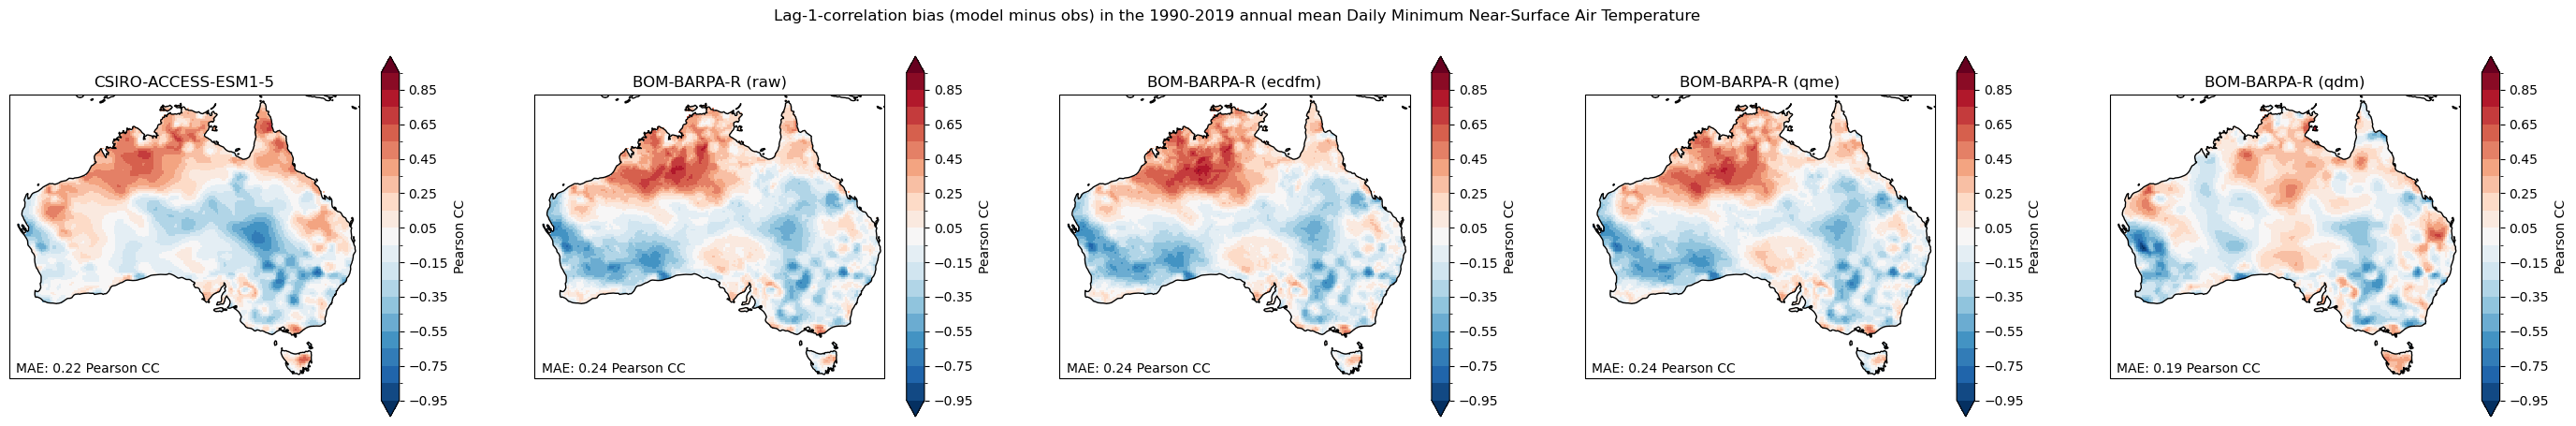

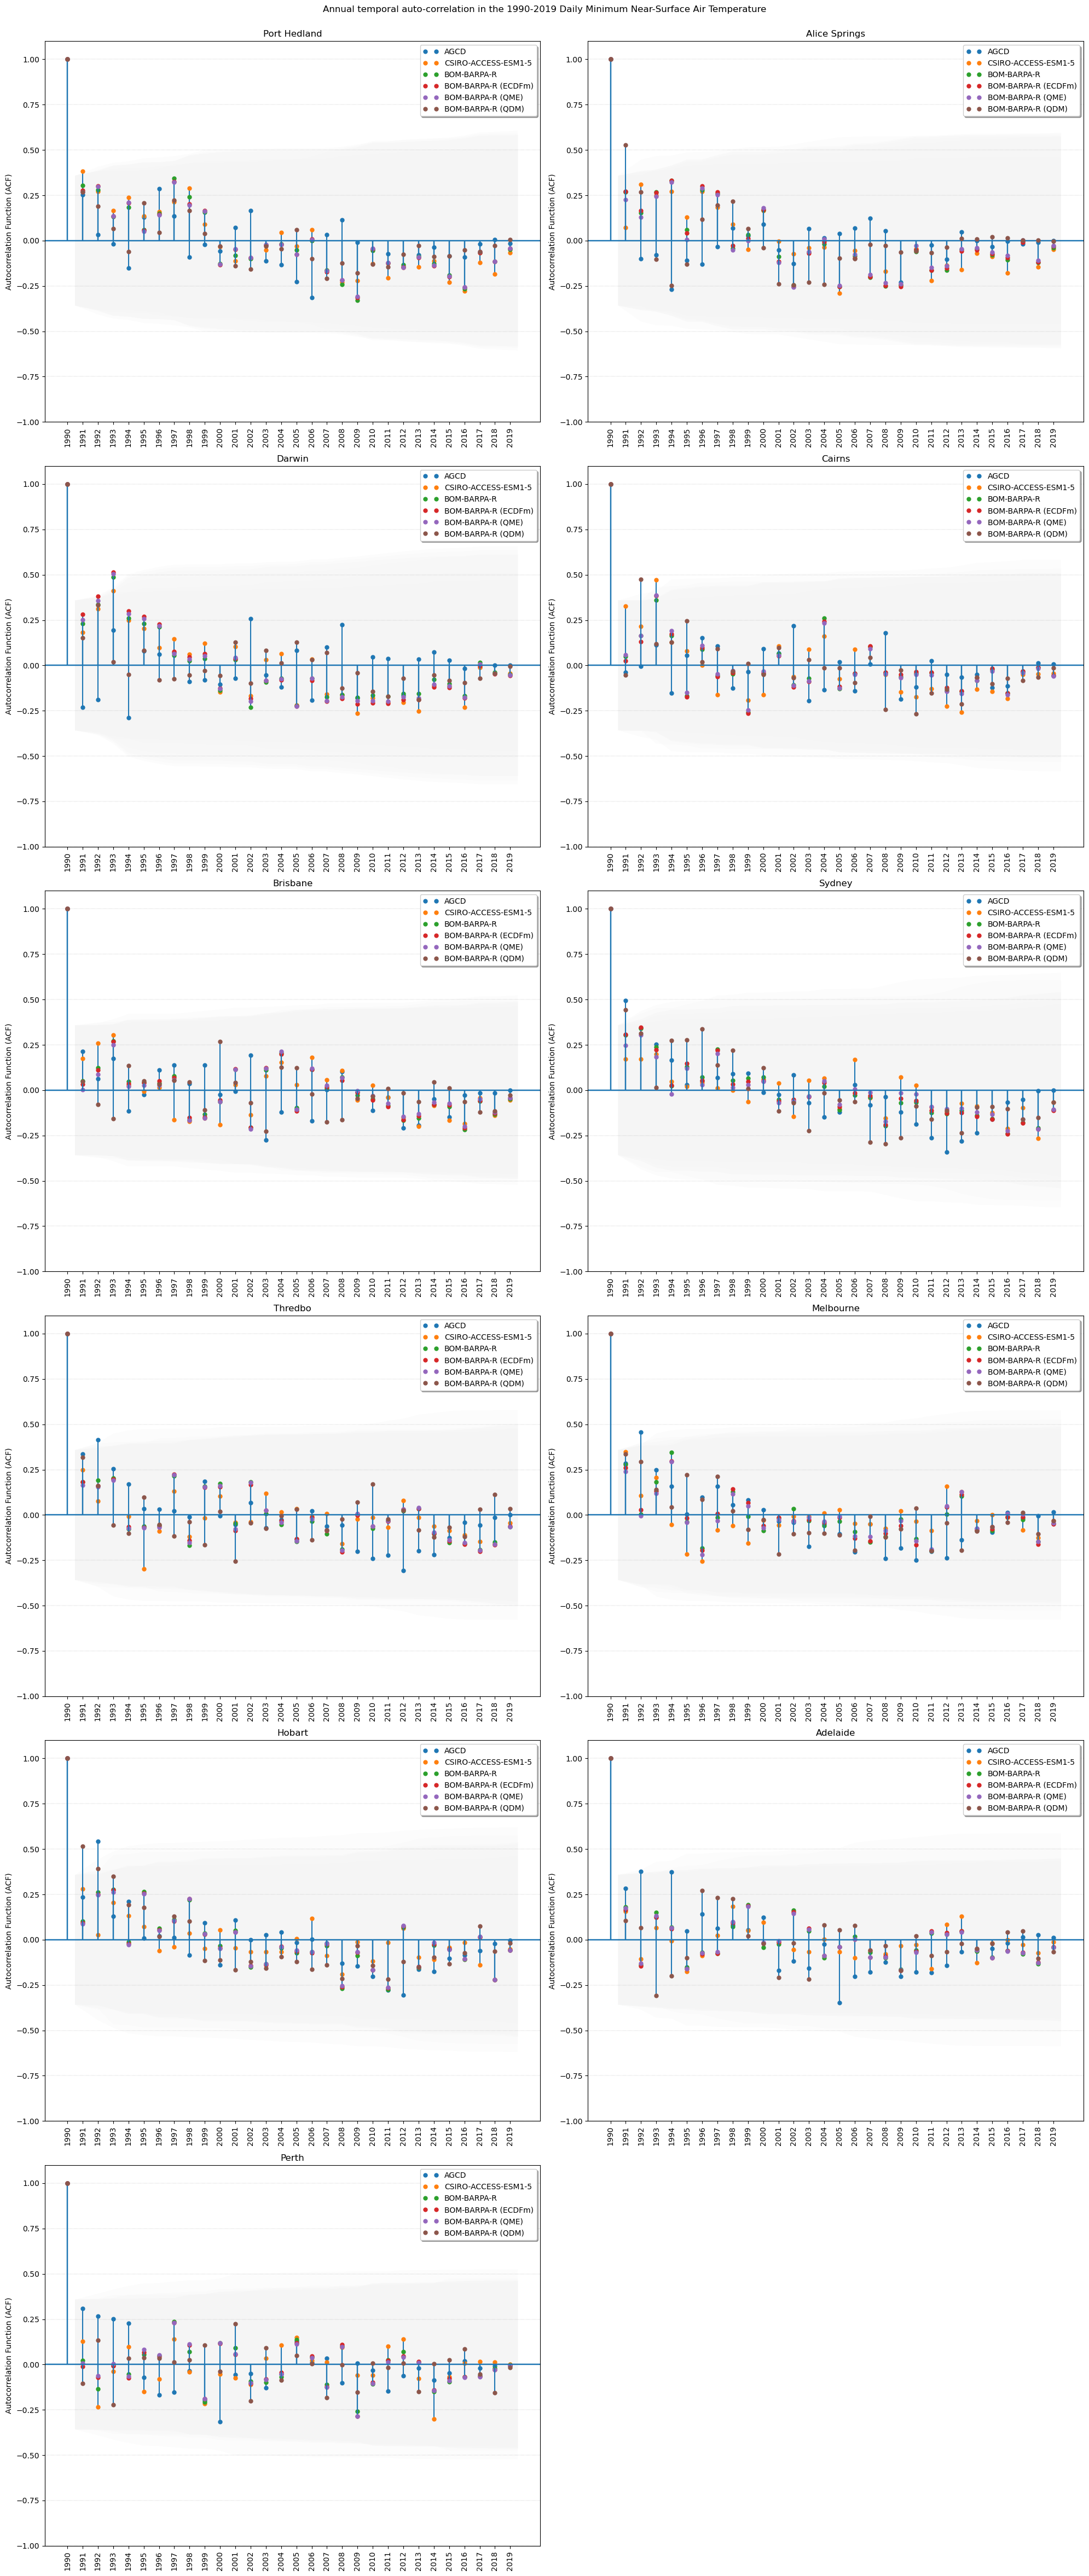

In [23]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'xvalidation', cmap, levels)
plot_city_tac(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'xvalidation')

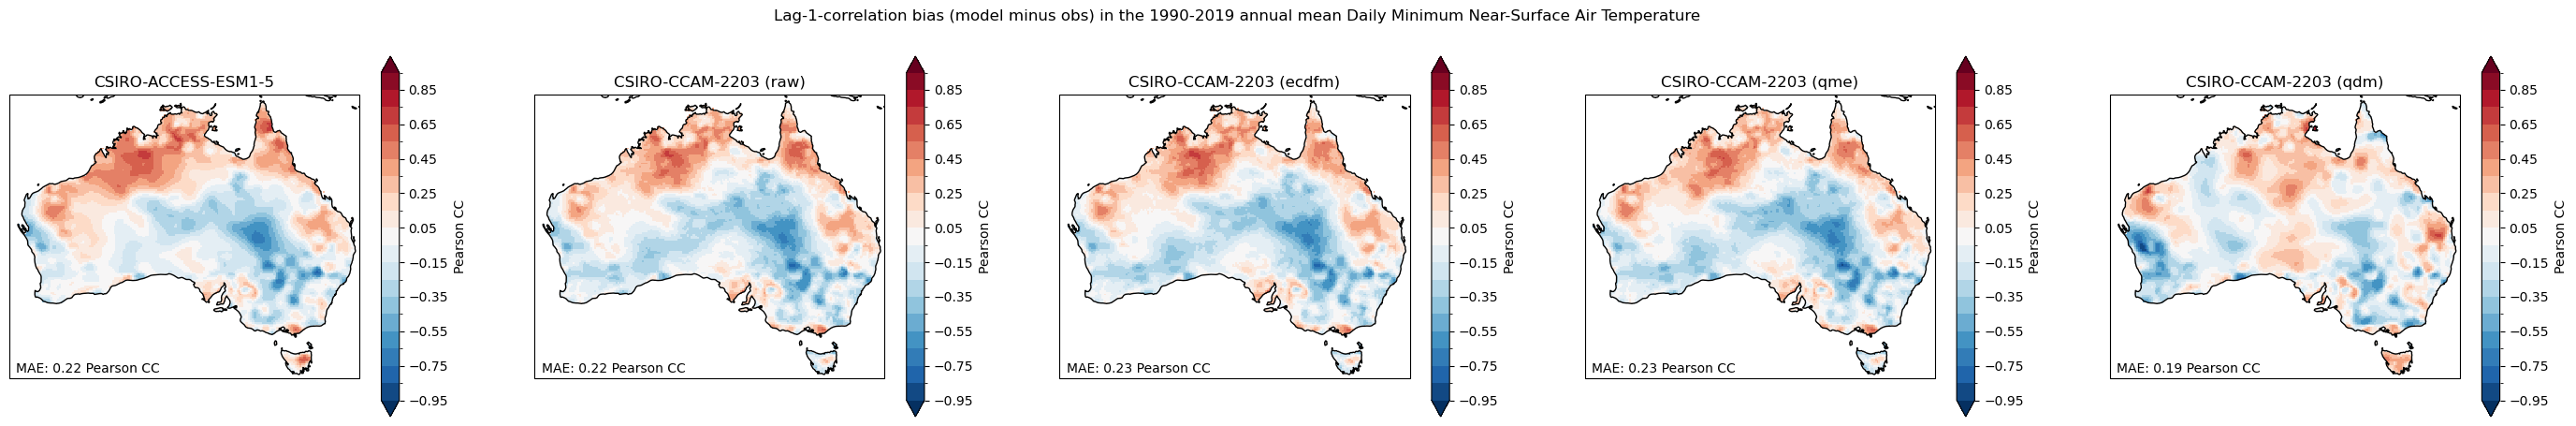

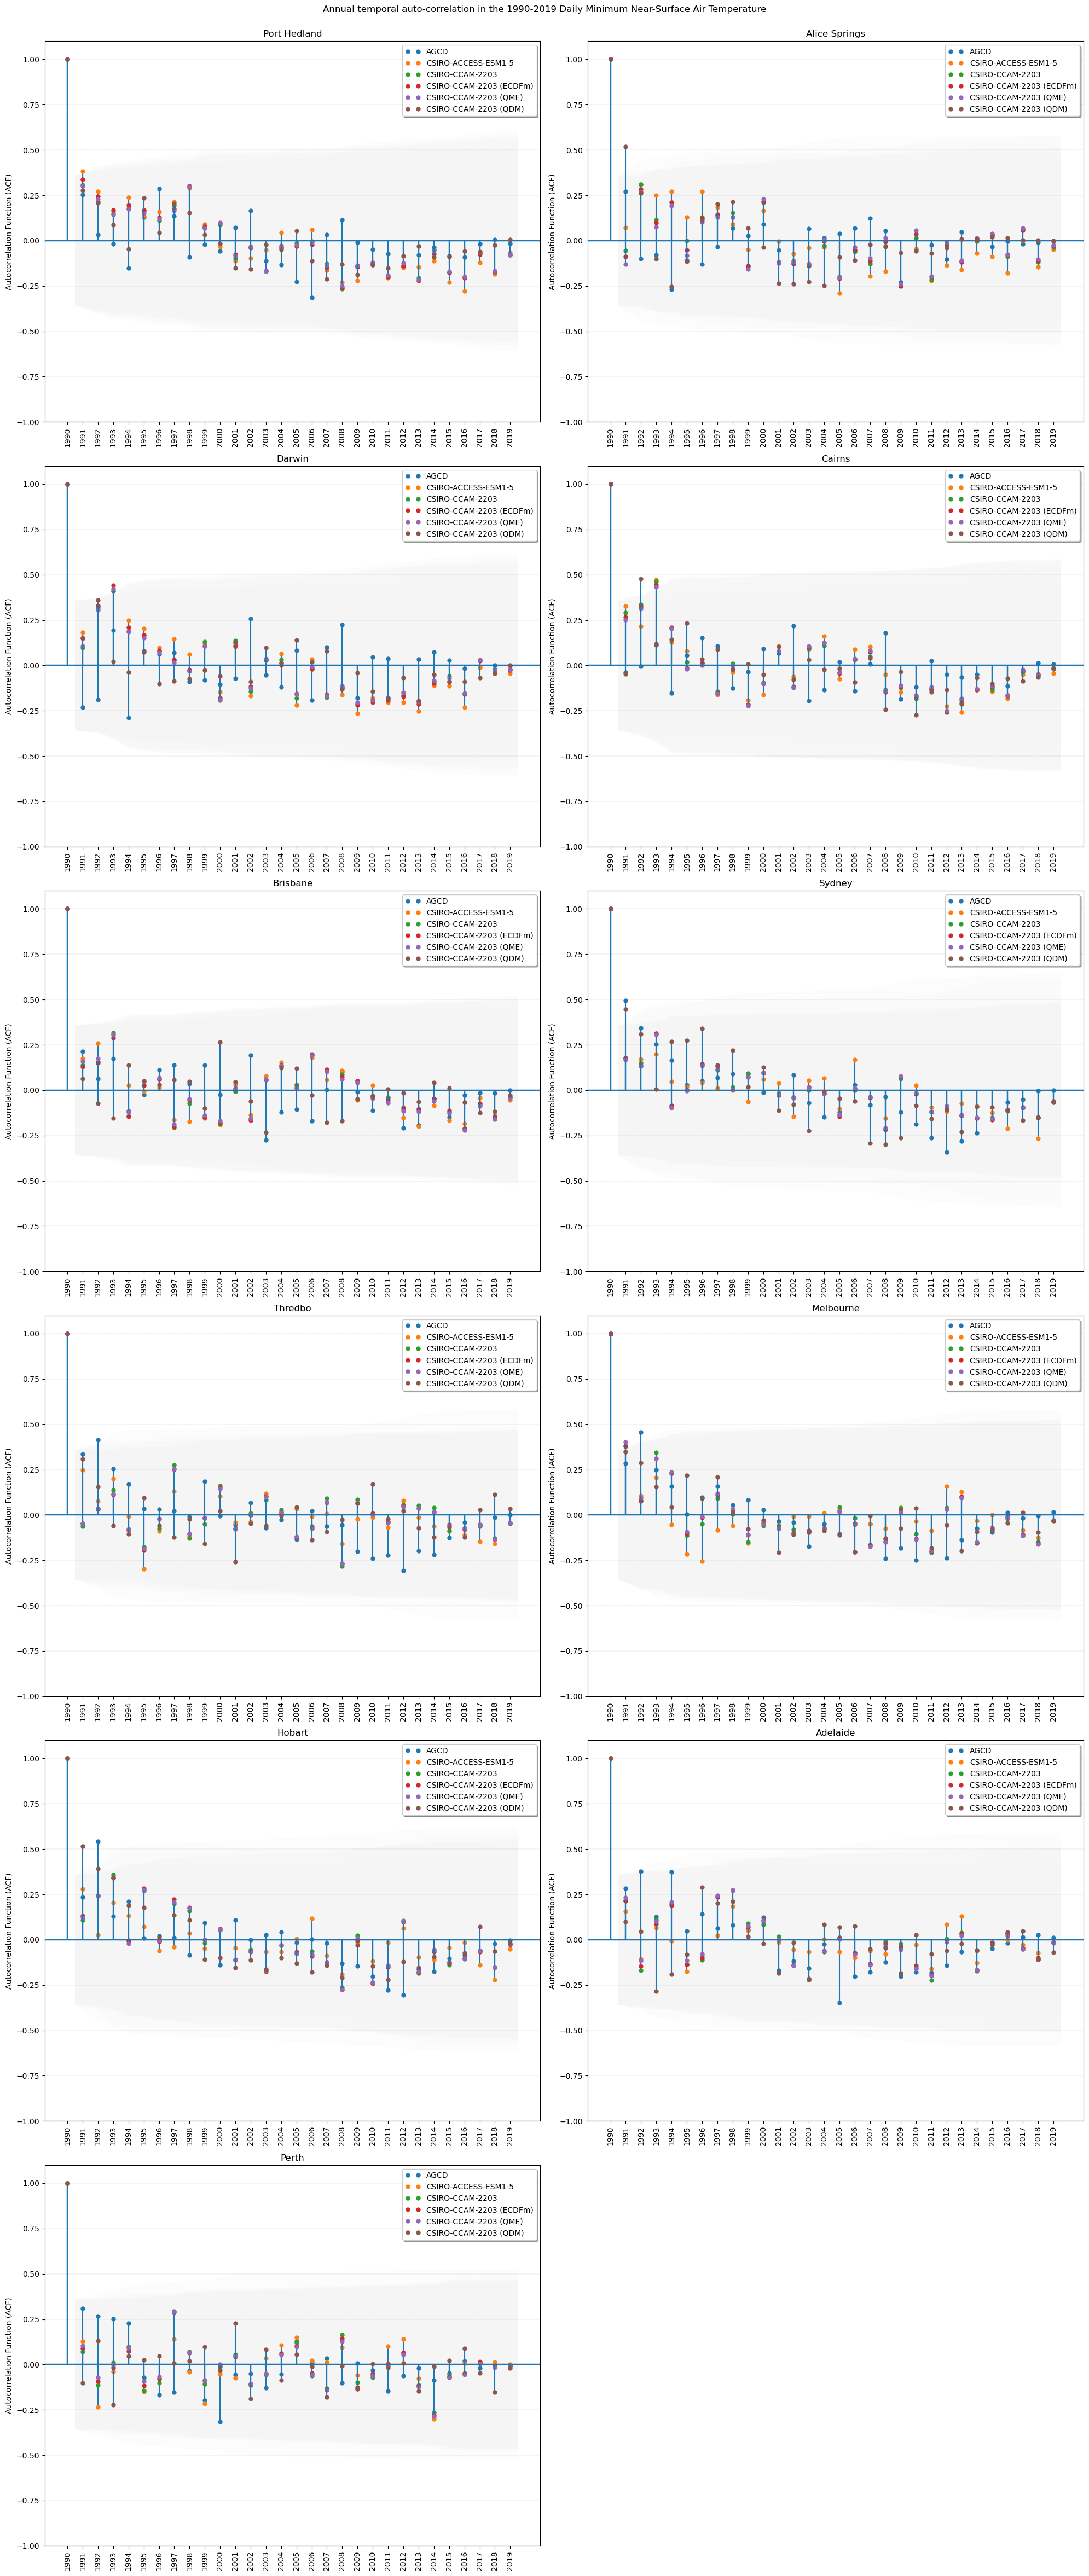

In [24]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'xvalidation', cmap, levels)
plot_city_tac(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'xvalidation')

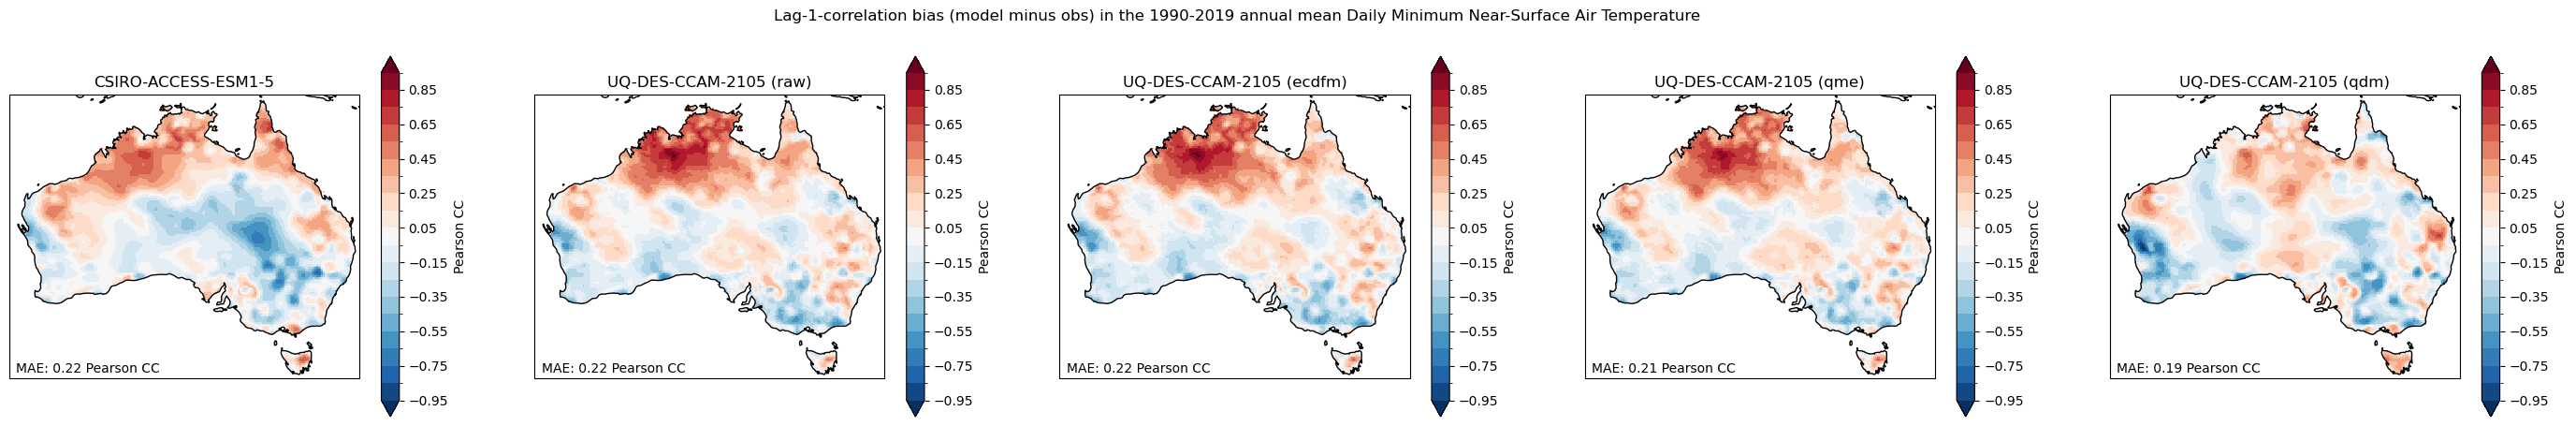

In [ ]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'xvalidation', cmap, levels)

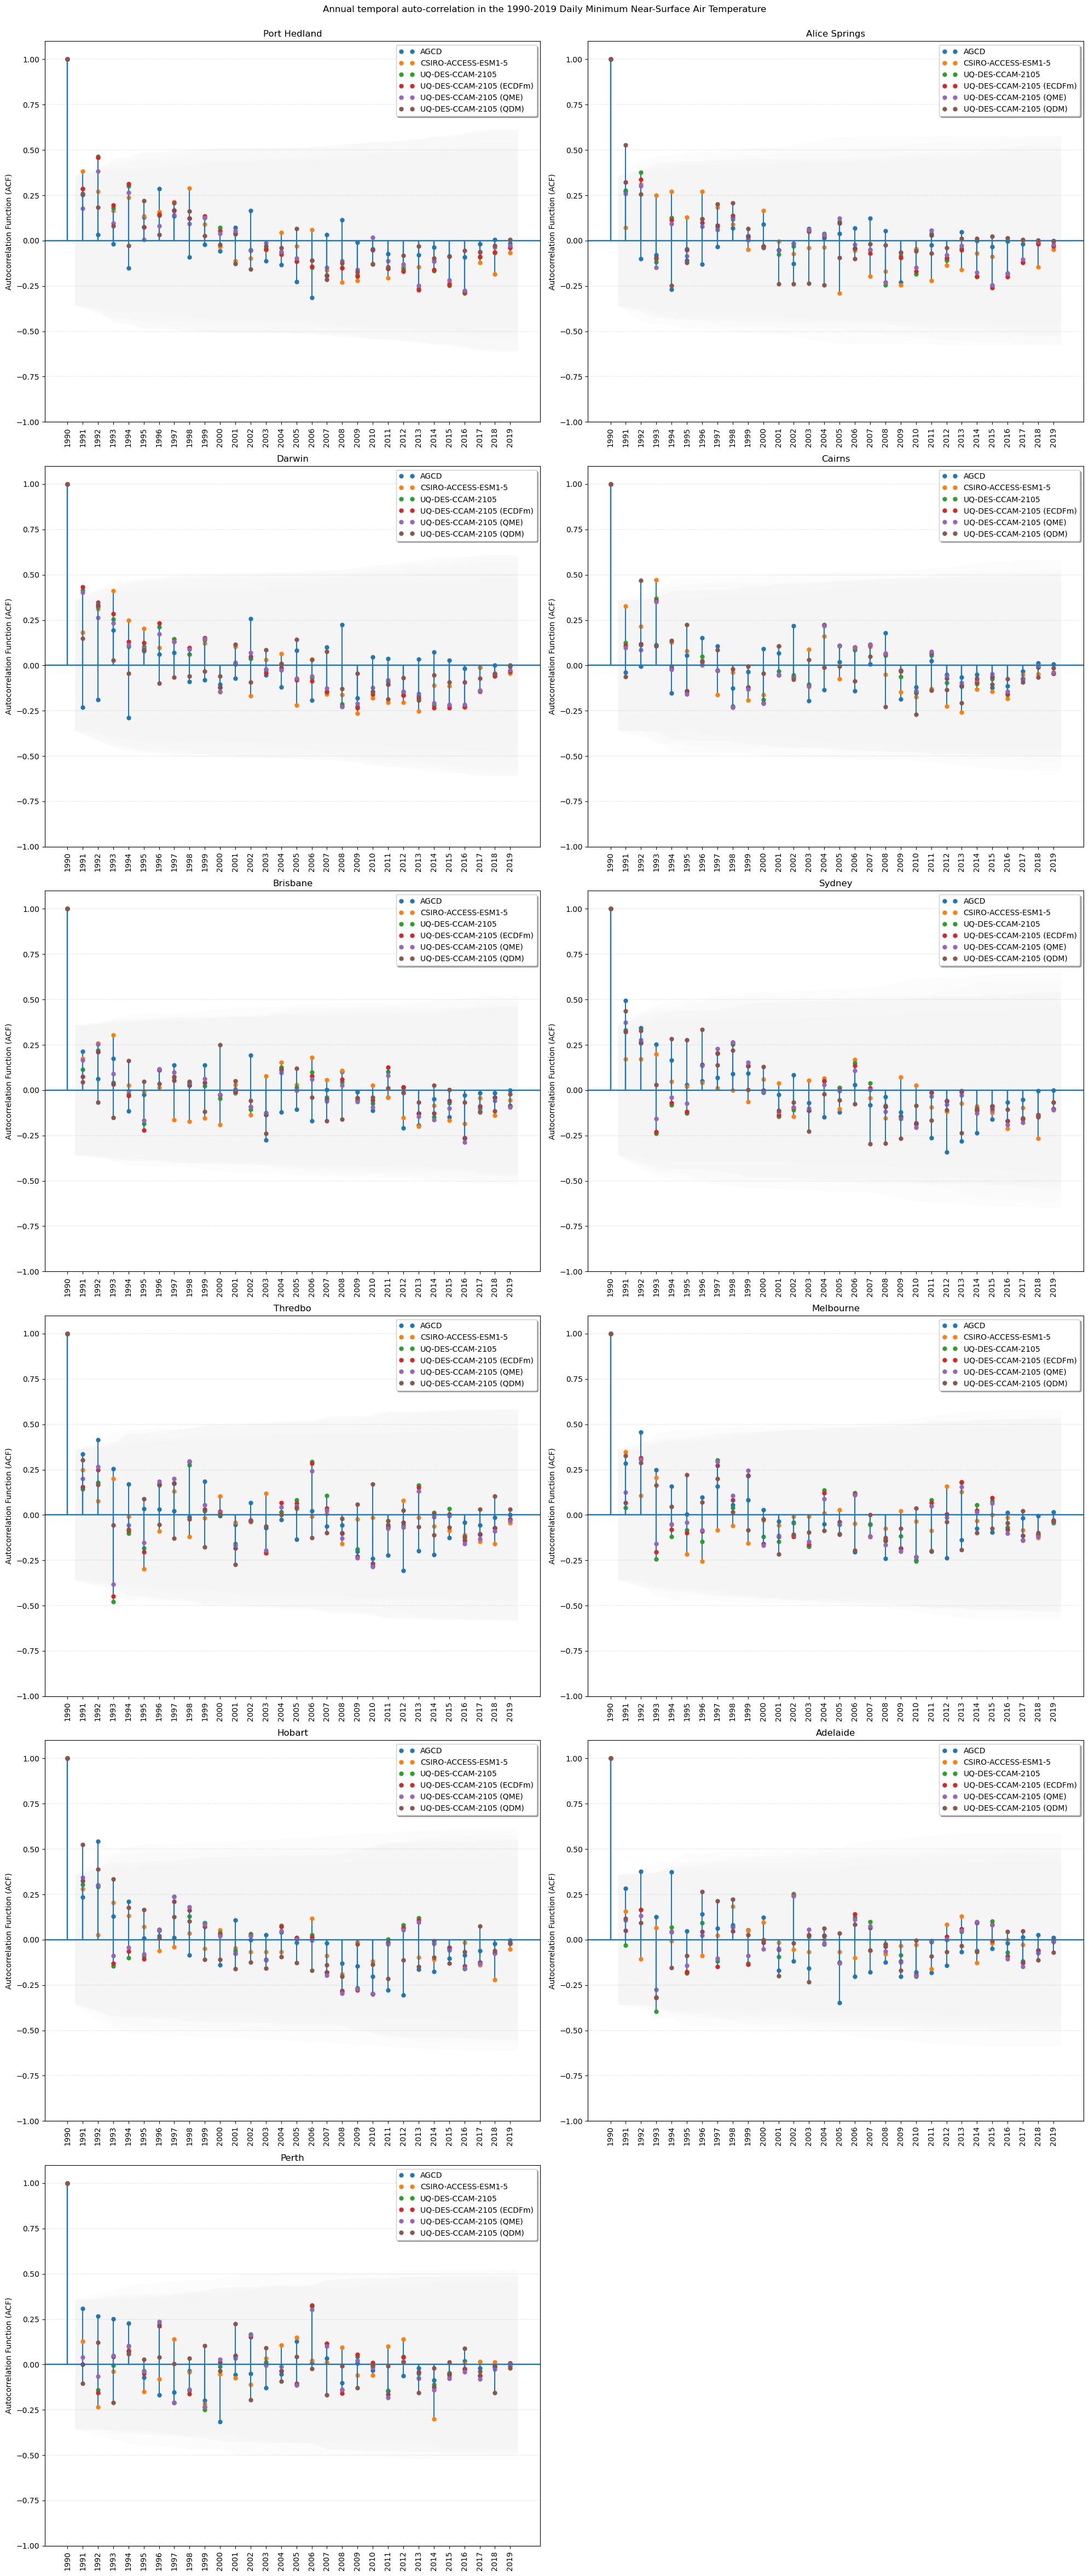

In [10]:
plot_city_tac(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'xvalidation')